<a href="https://colab.research.google.com/github/dnf6541/ME592HW2_IMAGEANALYTICS1/blob/main/Homework2_Question_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture

!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

Below are the basic Libraries needed for the project 

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
# Importing libraries

import cv2
import numpy as np
from google.colab.patches import cv2_imshow


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Reading the images

rawImage1 = ('/content/1.jpg')


rawImage2 = ('/content/2.jpg')

In [ ]:
image1 = cv2.imread(rawImage1,1)
image2 = cv2.imread(rawImage2,1)



The below code used to remove horizontal lines from the images 

In [ ]:
def remove_horizontal(image_horizontal,weight):
    original = image_horizontal.copy()
    gray = cv2.cvtColor(image_horizontal, cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
    detected_lines = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,
    horizontal_kernel, iterations=2)

    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(original, [c], -1, (255, 255, 255), 2)

    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, weight))

    result = 255 - cv2.morphologyEx(255 - image_horizontal, cv2.MORPH_CLOSE, repair_kernel,
    iterations=1)

    # cv2_imshow(result)
    # cv2.waitKey()
    # cv2.destroyAllWindows()
    return(result)

In [ ]:
image1 = remove_horizontal(image1,4)
image2 = remove_horizontal(image2,3)

The code below is used in cropping the image manually 

In [ ]:
# Cropping the image manually

#Manually cropping the image into separate sections
slide1 = image1[15:230, 30:310]
slide2 = image1[15:230, 330:610]
slide3 = image1[310:530, 30:310]
slide4 = image1[310:530, 330:610]
slide5 = image1[600:830, 30:310]
slide6 = image1[600:830, 330:610]

# image2 = cv2.imread(rawImage2,1)

slide7 = image2[15:230, 20:340]
slide8 = image2[15:230, 400:720]
slide9 = image2[320:510, 20:340]
slide10 = image2[320:510, 400:720]
slide11 = image2[640:810, 20:340]
slide12 = image2[640:810, 400:720]

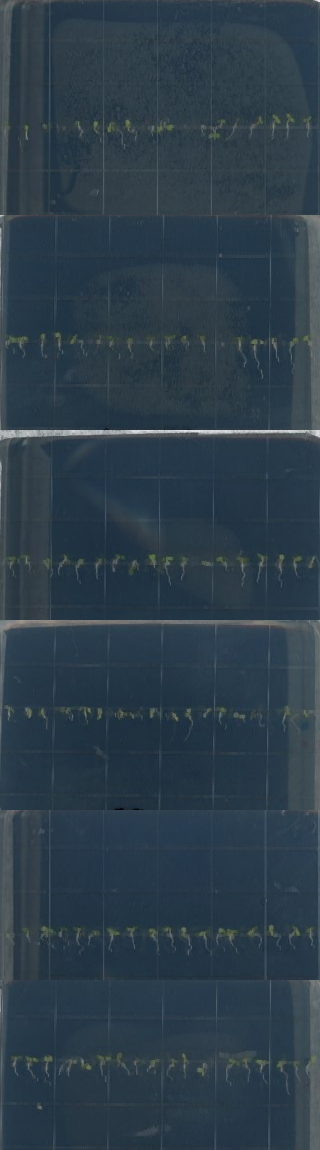

In [ ]:
#Checking the cropped images
# cv2_imshow(np.vstack((slide1,slide2,slide3,slide4,slide5,slide6)))
# cv2_imshow(np.vstack((slide7,slide8,slide9,slide10,slide11,slide12)))

In [ ]:
# original = slide1.copy()

In [ ]:
Edge detection applied to detect the edges of the images 

In [ ]:
# canny edge detection
# Performance inferior to Sobel but is already in uint8 dtype

def edgeDetectCanny(image):

  # Converting image to gray scale
  img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Blurring the image to reduce noise
  img_blur = cv2.GaussianBlur(img_gray,(1,3), sigmaX=0, sigmaY=0)

  # Canny Edge Detection
  edges = cv2.Canny(image=img_blur, threshold1=70, threshold2=70)

  # Display Canny Edge Detection Image
  # cv2_imshow(edges)

  return edges

In [ ]:
# edgeDetectCanny(slide1)

In [ ]:
# cv2_imshow(slide1)

Applying the masking so as the small shapes can be extracted 

In [ ]:
# Applying the mask to the image
# To do : Change it so that it does not resemble the stack overflow code, Play with parameters to get closer to the edge

def extractForeground(image, BLUR = 1, MASK_DILATE_ITER = 2, MASK_ERODE_ITER = 0):
  # Parameters to tune
  # BLUR = 1
  # MASK_DILATE_ITER = 2
  # MASK_ERODE_ITER = 0
  MASK_COLOR = (0.0,0.0,0.0) # In BGR format

  # image = remove_horizontal(image)
  edges = edgeDetectCanny(image)
  edges = cv2.dilate(edges, None)

  #-- Find contours in edges
  contour_info = []
  contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
  

  #-- Create empty mask, draw filled polygon on it corresponding to largest contour ----
  # Mask is black, polygon is white
  mask = np.zeros(edges.shape)  
  # cv2_imshow(mask)
  for i in contours:
    cv2.fillConvexPoly(mask, i, (255))
  
  # cv2_imshow(mask)

  mask = cv2.dilate(mask, None, iterations=MASK_DILATE_ITER)
  # cv2_imshow(mask)

  mask = cv2.erode(mask, None, iterations=MASK_ERODE_ITER)
  # cv2_imshow(mask)

  mask = cv2.GaussianBlur(mask, (BLUR, BLUR), 0)
  # cv2_imshow(mask)

  mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
  # cv2_imshow(mask_stack)


  mask_stack  = mask_stack.astype('float32')          # Use float matrices, 
  image         = image.astype('float32')                 #  for easy blending

  masked = (mask_stack * image) + (MASK_COLOR) # Blend
  masked = (masked*255).astype('uint8')                     # Convert back to 8-bit 

  # cv2_imshow(masked)
  return masked

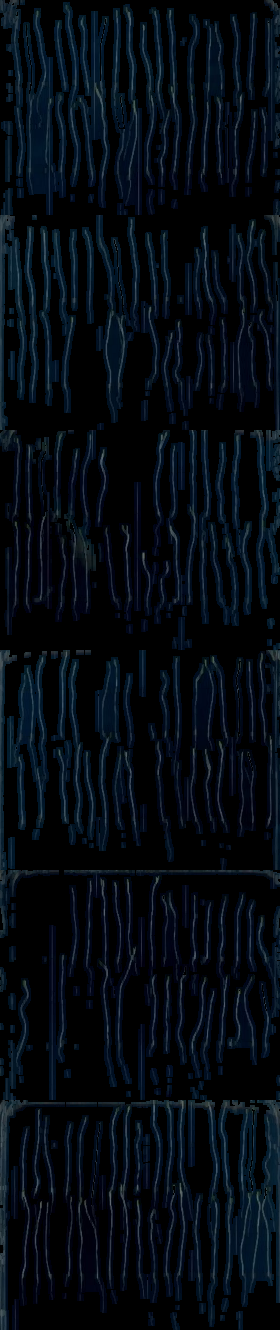

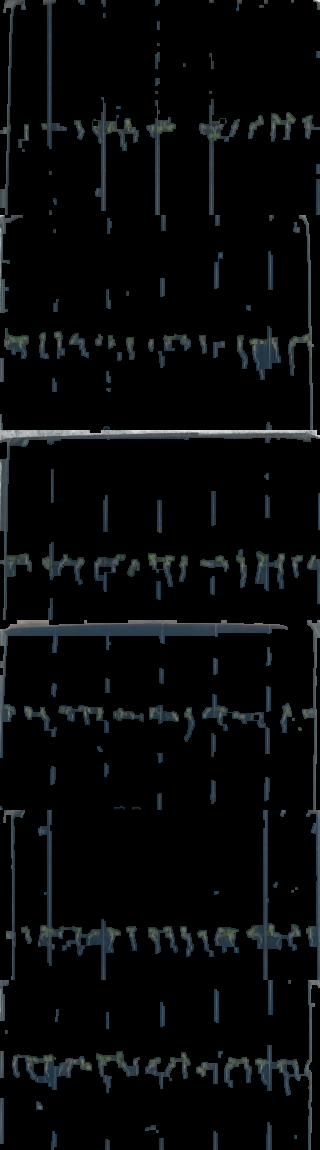

In [ ]:
# Looping over all the slides in the image

slideList1 = [slide1,slide2,slide3,slide4,slide5,slide6]
slideList2 = [slide7,slide8,slide9,slide10,slide11,slide12]

result1 = []
result2 = []
for slide in slideList1:
  result1.append(extractForeground(slide,1,1,0))

cv2_imshow(np.vstack(result1))

for slide in slideList2:
  result2.append(extractForeground(slide,1,2,2))

cv2_imshow(np.vstack(result2))


In [ ]:
extractForeground(slide6,1,2,0)